## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.


**Requirements**

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the Tavily Search Engine, and set your TAVILY_API_KEY.

In [ ]:
# %%capture --no-stderr
# %pip install -U tavily-python langchain_community

Set your API Keys

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

##### Remove existing env var

In [ ]:
def _unset_env(var: str):
    if var in os.environ:
        del os.environ[var]

_unset_env("ANTHROPIC_API_KEY")

Next, define the tool

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

In [ ]:
search_tool.invoke("Who won the 2024 US election?")

[{'url': 'https://www.latimes.com/politics/story/2024-11-06/trump-defeats-harris-47th-president-election-2024',
  'content': 'Trump wins 2024 U.S. presidential election - Los Angeles Times Trump elected 47th president of the United States, defeating Harris to retake White House Nancy Northup, President and CEO of the Center for Reproductive Rights, called Trump’s win “a deadly threat to the democratic values of liberty and equality, the rule of law, and reproductive health, rights, and justice in the United States and around the globe.” “The Democrats thought there were enough people who hated Trump or were willing to fear him to win the race,” Jennings said. 2024 election results: Trump wins second term in historic comeback'},
 {'url': 'https://www.bbc.com/news/election/2024/us/results',
  'content': 'US Presidential Election Results 2024 - BBC News Close menu BBC News Kamala Harris of the Democrat party has 0 electoral college votes. Donald Trump of the Republican party has 0 elector

**The results are page summaries our chat bot can use to answer questions.**



Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added `bind_tools` on our LLM. 


This lets the LLM know the correct JSON format to use if it wants to use our search engine.


In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI



class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.2", temperature=0)
# llm = ChatGroq(model="mixtral-8x7b-32768")
# llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")
# llm = ChatOpenAI(model="gpt-4o-mini")

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}



graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. 

It relies on the LLM's `tool_calling` support, which is available in LLama, Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt `ToolNode` to speed things up, but building it ourselves first is instructive.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Recall that edges route the control flow from one node to the next. 

Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. 

These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. 


Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt `tools_condition` to be more concise, but implementing it ourselves first makes things more clear.

In [ ]:
from typing import Literal


def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.


graph_builder.add_edge(START, "chatbot")

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,

    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    
    {"tools": "tools", END: END},
)


# Any time a tool is called, we return to the chatbot to decide the next step

graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

Notice that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt `tools_condition`, our function returns the `END` string if no tool calls are made. When the graph transitions to `END`, it has no more tasks to complete and ceases execution. Because the condition can return END, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

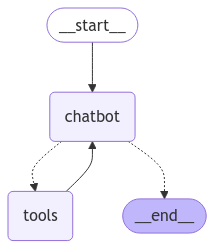

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph Cloud?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.cnn.com/", "content": "2024 Elections US World Politics Business Health Entertainment Style Travel Sports Underscored Science Climate Weather Ukraine-Russia War Israel-Hamas War Black Friday Deals CNN10 About CNN Daniel Ramalho/AFP/Getty ImagesWorld leaders wondering what the next four years will hold got a clue from a Trump ally at the G20 \u2022 Video 2:50 CNNVideo CNN reporter asks Trump fans at UFC event where they get their news 2:50 \u2022 Analysis Analysis Brandon Bell/Getty ImagesAnalysis Trump\u2019s pick for fracker-in-chief will have a tough time pumping a lot more oil More from CNN \u2022 Video 0:52 CNNVideo Anderson Cooper shows you how to vote for CNN Hero of the Year 0:52 \u2022 Track Track Bill Pugliano/Getty ImagesTrack Here are Trump\u2019s picks for key posts so far CNN10 About CNN"}, {"url": "https://www.nytimes.com/", "content": "5 min read\nEzra Klein\nThe Unsettling Lesson of the OpenAI Mess\n7 min read\nThomas B. Edsa

**Congrats!** You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. 


Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add memory to address this.


The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt `ToolNode`, and our `route_tools` condition with the prebuilt `tools_condition`

#### Full Code

In [ ]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm = ChatOllama(model="llama3.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.set_entry_point("chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()
